# Subset discontinuity tracking
This deck contains proofing of subset splitting methodologies

In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%autoreload 2

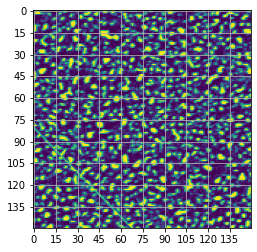

In [27]:
# preamble
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from crosspy import DIC, Imset
import os
import cv2

# folder path

folder_path=Path(r'D:\DIC\crosspy\data\Subset_tester')
Images = Imset(folder_path,'tif')

# Image crop

crop_on = False

if crop_on:
    img = Images.imload([0,1])
    y = 200
    h = 1000
    x = 600
    w = 1000
    Images = img[y:y+h, x:x+w, :]
else:
    Images = Images.imload([0,1])
   
fig = plt.figure()
ax = fig.gca()
ax.imshow(Images[:,:,1])
ax.set_xticks(np.arange(0, Images.shape[0], Images.shape[0]/10))
ax.set_yticks(np.arange(0, Images.shape[1], Images.shape[0]/10))
plt.grid()


Running sequential DIC on image pair 1 of 1 ...
... Completed in (s) 2.116380214691162


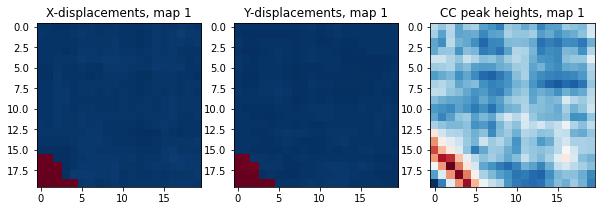

In [28]:
# Image crop

roi_1stpass = dict(size_pass = 50, overlap_percentage = 90, xcf_mesh=250)
filter_settings = [4,2,15,8]
# first pass

dic_1stpass = DIC(Images,roi_1stpass,filter_settings)
dic_1stpass.run_sequential(cores=4)

dic_1stpass.plot_displacements()
#images_corrected = dic_1stpass.correct(method='polynomial',printing=1)

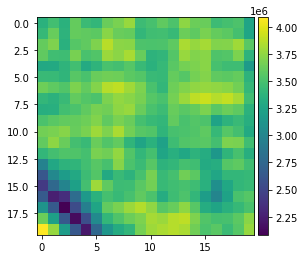

In [29]:
cc_peaks = dic_1stpass.ph_maps[:,:,0]
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.subplot(111)
im = ax.imshow(cc_peaks)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

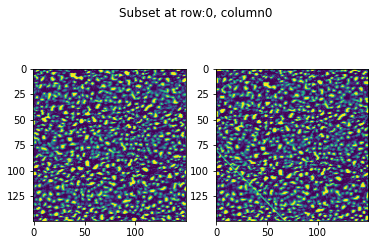

In [62]:
import cv2
filter_settings=[4,2,15,8]
ims = Images
#settings for heaviside pass
roi_disc = dict(size_pass = 150, overlap_percentage = 0, xcf_mesh=250)
dic_disc = DIC(ims, roi_disc,filter_settings)

# Function to plot selected subsets

def get_subsets(ims, row=3, col=1, roi_settings=None):
    if roi_settings==None:
        roi_settings = dict(
            size_pass = 100, 
            overlap_percentage = 70, 
            xcf_mesh=250)
    x0 = (col) * roi_settings['size_pass']
    x1 = x0 + roi_settings['size_pass']
    y0 = (row) * roi_settings['size_pass']
    y1 = y0 + roi_settings['size_pass']
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Subset at row:{}, column{}'.format(row,col))
    images = []
    for i in range(0,ims.shape[2]):
        images.append(axs[i].imshow(ims[x0:x1, y0:y1, i]))
        
    subsets = ims[x0:x1, y0:y1, :]
    return subsets


    
# Select a subset, here at row 20, column 20

#subsets = get_subsets(ims,5, 0, roi_disc) # has slip
subsets = get_subsets(ims,0, 0, roi_disc) # has no slip


In [63]:
from numba import double, jit
from numba.experimental import jitclass
from numba import int32, float32, uint8
import numpy as np

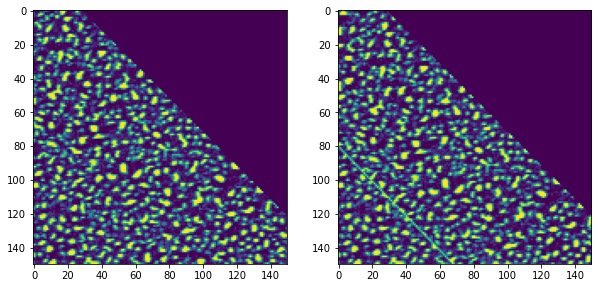

In [64]:


# Apply a line and step function

spec = [
    ('x', float32),
    ('y', float32)
]

@jitclass(spec)
class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y 

@jit(nopython=True)
def line_test(pixel, r, theta, subsets):
    # function to test if a pixel lies above or below a line segment
    # Find start and end points of line segments for different cases of theta and r
    dx = subsets.shape[0]
    # Line segment to interogation point
    p1 = Point(0, 0)
    q1 = Point(pixel[0], pixel[1])
    
    # Vector magnitude cases
    #theta = np.degrees(theta)
    theta = theta % 360
    if r == 0:
        r = 1e-8
        
    # Rotation cases
    if theta == 0. or theta == 360.: # vertical to right
        x1 = r
        x2 = q1.x
        if x2 > x1:
            return False
        else:
            return True
    elif theta == 90.: # horizontal line above
        y1 = r
        y2 = q1.y
        if y2>y1:
            return False
        else:
            return True
    elif theta == 180.: # vertical to left
        x1 = -r
        x2 = q1.x
        if x2 > x1:
            return True
        else:
            return False
    elif theta == 270.: # horizontal below
        y1 = -r
        y2 = q1.y
        if y2 < y1:
            return False
        else:
            return True
    elif theta>0 and theta<180:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        y1 = q1.y
        y2 = m*q1.x + c
        if y1>y2:
            return False
        else:
            return True
    elif theta>180 and theta<360:
        theta = np.radians(theta)
        # Tangent line segment
        t1 = Point(r*np.cos(theta), r*np.sin(theta))
        m = -1*(np.cos(theta)/np.sin(theta))
        c = t1.y - m*t1.x
        
        y1 = q1.y
        y2 = m*q1.x + c
        if y1<y2:
            return False
        else:
            return True
@jit(uint8[:,:,:](uint8[:,:,:], float32, float32)) 
def subset_hsfilter(subsets, r, theta):
    # preallocate arrays
    hsfilter = np.zeros((subsets.shape[0],subsets.shape[0]))
    xc = hsfilter.shape[0]/2
    yc = hsfilter.shape[1]/2
    xc = int(xc)
    yc = int(yc)
    
    # Create x and y coordinates which are centred
    xs,ys = np.meshgrid(range(-xc, xc), range(-yc,yc))
    
    # iterate pixel by pixel
    for col in range(subsets.shape[0]):
        for row in range(subsets.shape[0]):
            #rasters through columns and rows for a given coordinate in xy
            x = xs[row,col]
            y = ys[row,col]
            # Note that y axis is mirrored
            pixel = [x, (-1*y)]
            # Test if pixel is beyond the discontinuity line
            flag  =line_test(pixel, r, theta, subsets)
            if flag:
                hsfilter[row,col] = True
            else:
                hsfilter[row,col] = False
                
    hs_subset = np.zeros(subsets.shape)
    hs_subset[:,:,0] = np.multiply(hsfilter,subsets[:,:,0])
    hs_subset[:,:,1] = np.multiply(hsfilter,subsets[:,:,1])
    return hs_subset



result = subset_hsfilter(subsets,r=20, theta=45)

f, axarr = plt.subplots(1,2, figsize=(10,5))
axarr[0].imshow(result[:,:,0])
axarr[1].imshow(result[:,:,1])


Testing various correlation functions below

# FREG hs corr:

---> FXCORR is already the fastests and most accurate function available --> alternatively rewrite as a lightweight correlation function without subpixel registration

In [65]:
from crosspy import XCF

def hs_corr(x, subsets, d, prepared_ffts):
    # unpack vector
    r, theta = x
    # apply heaviside filter
    filtered_subsets = subset_hsfilter(subsets, r, theta)
    
    # assign to clean variables for legibility
    a = filtered_subsets[:,:,0]
    b = filtered_subsets[:,:,1]
    
    # cross correlate using freg - this is still faster than silly numpy correlate
    result = XCF.fxcorr(a, b, d, prepared_ffts)
    
    # normalise via division by active pixels
    act_px = np.count_nonzero(a != False)
    result = np.asarray(result)
    result[2] = result[2]/act_px
    
    # return vectorised result containign dx,dy,cc
    return result

prepared_ffts = XCF.plan_ffts(dic_disc)
tester = hs_corr([16,70], subsets, dic_disc, prepared_ffts)


In [66]:
from skopt import Optimizer

from matplotlib.colors import Normalize
prepared_ffts = XCF.plan_ffts(dic_disc)
def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    return dx,dy,c

#@jit
def map_hscorr(n,ia,d,prepared_ffts):
    
    #preallocate:
   
    # r and theta range
    
    rs = np.linspace(0,ia.shape[2]/2,n)
    theta = np.linspace(0,360,n*3)
    theta = np.radians(theta)
    z = np.zeros((len(rs),len(theta),3))
    # meshgrid is not compilable
    for i, r in enumerate(rs):
        for j, th in enumerate(theta):
            dx,dy,dz = hsin([r,th],ia,d,prepared_ffts)
            z[i,j,0] = dx
            z[i,j,1] = dy
            z[i,j,2] = dz
    return z


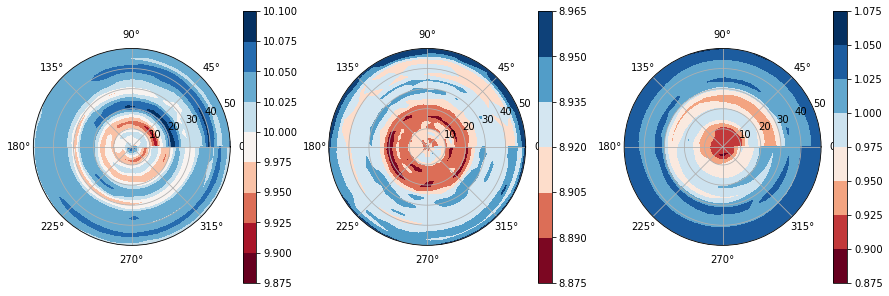

In [67]:
# Plotting as polar figure
import numpy as np
import matplotlib.pyplot as plt

#gen data
n= 5

#subsets = ia
a = subsets[:,:,0]
b = subsets[:,:,1]
dx0, dy0, cc0 = XCF.fxcorr(a, b, dic_disc, prepared_ffts)
cc0 = cc0/(a.shape[0]**2)
thetas = np.radians(np.linspace(0, 360, 50))
#theta_rad = np.radians(np.linspace(0, 360, 20))
rs = np.linspace(0, a.shape[0]/3, 20)
r, theta = np.meshgrid(rs, thetas)
vals = np.c_[r.ravel(),theta.ravel()]
fx = np.reshape([hsin(val,subsets,dic_disc,prepared_ffts) for val in vals],(len(theta),len(rs),3))

fx[:,:,2] = np.abs(fx[:,:,2]/cc0)

#plot
fig, ax = plt.subplots(1, 3, subplot_kw={'projection' :'polar'}, figsize=(15, 5))
for i in range(3): 
    aax = ax[i]
    aax.set_rlim(1, rs.max())
    z = fx[:,:,i]
    cmap = aax.contourf(theta, r, z,vmin=z.min(), vmax=z.max(), cmap='RdBu')
    fig.colorbar(cmap,ax=aax)



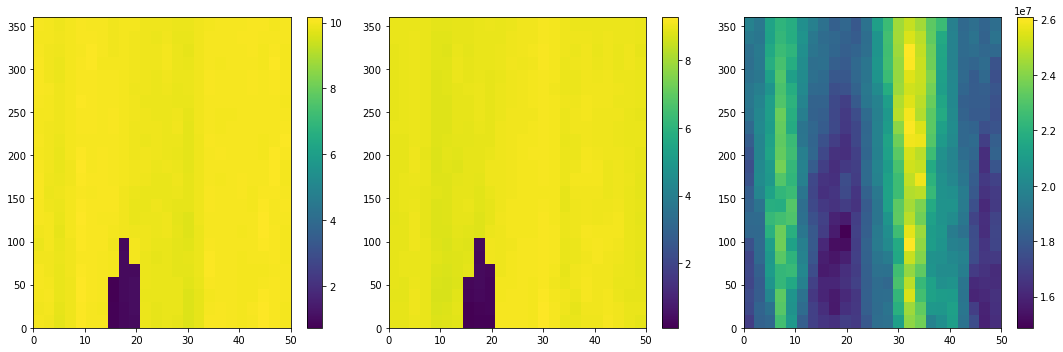

In [68]:
# Plotting as colormesh

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
n = 25
rs = np.linspace(0,subsets.shape[0]/3, n)
ths = np.linspace(0,360,n)
x,y = np.meshgrid(rs,ths)
z = np.zeros((x.shape[0],x.shape[1],3))
for i,r in enumerate(rs):
    for j,theta in enumerate(ths):
        z[i,j,:]=hs_corr([r,theta],subsets,dic_disc,prepared_ffts)

z[i,j,2] = z[i,j,2]
for i in range(3):
    ax = axs[i]
    fx = z[:,:,i]
    im = ax.pcolormesh(x,y,fx)
    fig.colorbar(im,ax=ax)

fig.tight_layout()

# Plotting in 3d

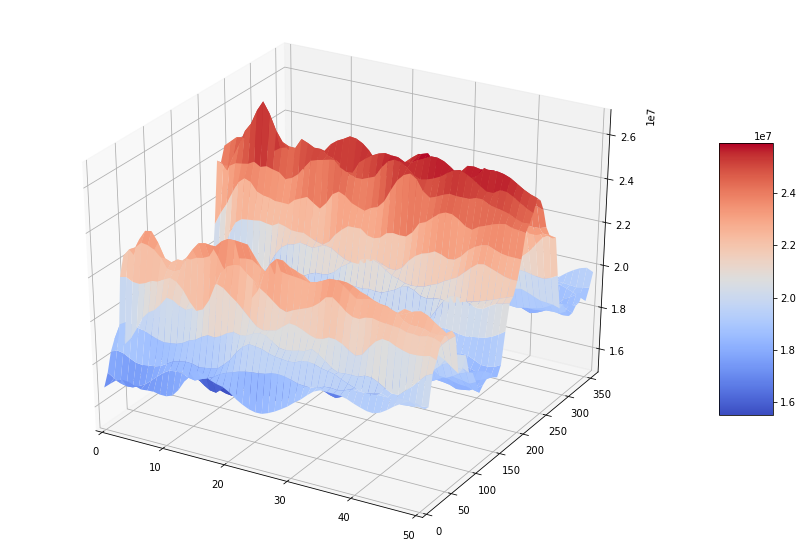

In [69]:
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    return dx,dy,c

n = 50
rs = np.linspace(0,subsets.shape[0]/3, n)
ths = np.linspace(0,360,n)
x, y = np.meshgrid(rs,ths)

vals = np.c_[np.ravel(x),np.ravel(y)]

fx = np.array([hsin(val, subsets, dic_disc, prepared_ffts) for val in vals]).reshape(n,n,3)

fig = plt.figure(figsize=(15,10))



ax = fig.gca(projection='3d')
z = fx[:,:,2]
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm)#, linewidth=0, antialiased=False)
ax.set_xlim(rs.min(), rs.max())
ax.set_ylim(ths.min(), ths.max())
ax.set_zlim(z.min(), z.max())
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


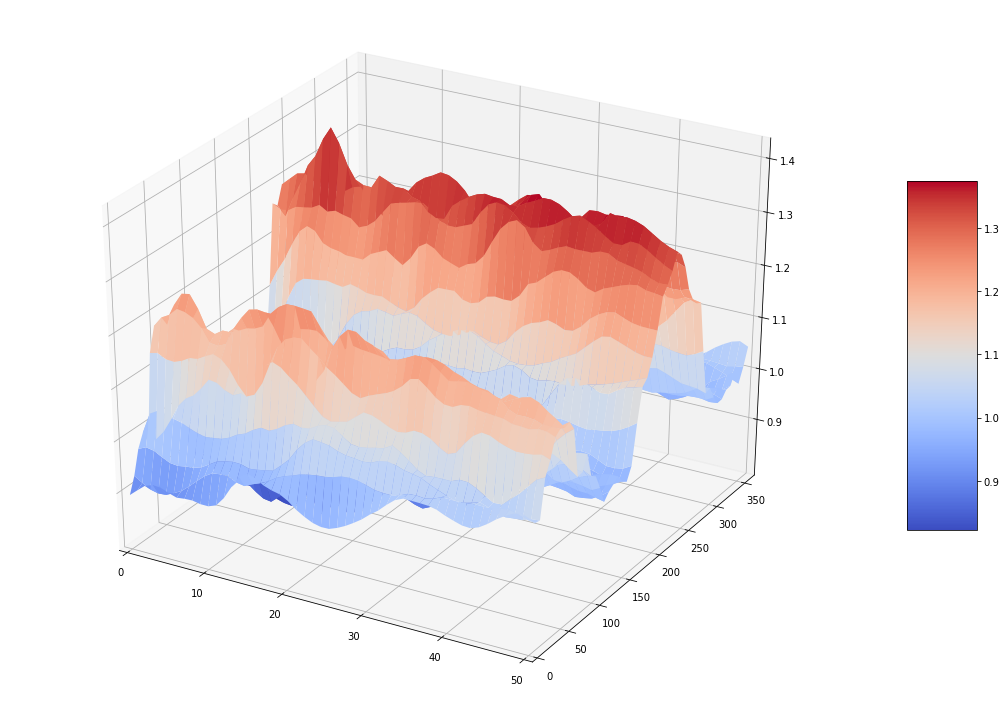

In [70]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
dx1, dy1, cc_org = XCF.fxcorr(subsets[:,:,0], subsets[:,:,1], dic_disc, prepared_ffts)
z = (fx[:,:,2])/(cc_org/subsets.shape[0]**2)
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm)#, linewidth=0, antialiased=False)
ax.set_xlim(rs.min(), rs.max())
ax.set_ylim(ths.min(), ths.max())
ax.set_zlim(z.min(), z.max())
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

In [15]:
loc = np.where(fx.max() == fx)

rmx = x[loc[0],loc[1]]
thsmx = y[loc[0],loc[1]]

print(rmx,thsmx)

NameError: name 'fx' is not defined

# Bayesian optimization for noisy, expensive, black box functions - no gradient descent needed - > GOOD FOR FIRST ORDER APPROXIMATION

In [71]:
from functools import partial
from skopt import gp_minimize, forest_minimize, dummy_minimize
def hsin(x,subsets,d,prepared_ffts):
    _,_,c=hs_corr(x,subsets,d,prepared_ffts)
    return -1.*c
@jit
def opt_rt(subsets, n_calls, d, prepared_ffts):
    # Initial naked search
    a = subsets[:,:,0]
    b = subsets[:,:,1]
    dx1, dy1, cc1 = XCF.fxcorr(a, b, d, prepared_ffts)
    # local function
    
    # define search boundary
    bounds = [(0., subsets.shape[0]/3), (0., 360.0)]
    func = partial(hsin, subsets=subsets,d=d, prepared_ffts=prepared_ffts)
    # Use a Bayesian-gauss optimisation to approximate minimum
    res = gp_minimize(func,                  # the function to minimize
                  bounds,      # the bounds on each dimension of x
                  acq_func="EI",      # the acquisition function
                  n_calls=n_calls,         # the number of evaluations of f
                  n_random_starts=5,  # the number of random initialization points
                  noise=1e-8,       # the noise level (optional)
                  random_state=1234)   # the random seed
    x = res.x
    r = np.around(x[0],2)
    theta = np.around(x[1],2)
    dx0, dy0, cc0 = hs_corr(x, subsets, d, prepared_ffts)
    # Accept the approximation only if the peak height is 
    # significantly higher than the naked cross correlation
    cc1 = cc1/(subsets.shape[0]**2)
    if np.abs(cc0/cc1) >= 1.0 and r != 0.0:     
        return dx0, dy0, cc0, r, theta, True
    else:
        return dx1, dy1, cc1, False, False, False


    
def minimize_rt(subsets,d,prepared_ffts):
    dx, dy, cc, r, theta, hson = opt_rt(subsets,20, d, prepared_ffts)
    #print("r = {}, theta = {}".format(r,theta))
    return dx,dy,cc,r,theta,hson

dx, dy, cc, r, theta, hson = minimize_rt(subsets,dic_disc, prepared_ffts)

print(r,theta)


15.73 218.89


# Dual Bayesian

In [18]:
def opt_rt(subsets, n_calls, d, prepared_ffts):
    # Initial naked search
    a = subsets[:,:,0]
    b = subsets[:,:,1]
    dx1, dy1, cc1 = XCF.fxcorr(a, b, d, prepared_ffts)
    # local function
    def hsin(x,subsets,d,prepared_ffts):
        _,_,c=hs_corr(x,subsets,d,prepared_ffts)
        return -1.*c
    
    # define search boundary
    bounds = [(0., ia.shape[0]/2), (0., 360.0)]
    func = partial(hsin, subsets=subsets,d=d, prepared_ffts=prepared_ffts)
    
    # Use a Bayesian-gauss optimisation to approximate start
    res = gp_minimize(func, bounds, n_calls=n_calls+10, n_random_starts=n_calls)
    x0 = res.x
    print(x0[0])
    
    bounds1 = [(x0[0]-5, x0[0]+5), (x0[0]-20, x0[0]+20)]
    bounds2 = [(x0[0]-5, x0[0]+5), (x0[0]-20+180, x0[0]+20+180)]
    print('res1 bounds', bounds1, 'res2 bounds', bounds2)
    res1 = gp_minimize(func, bounds1, n_calls=n_calls+10, n_random_starts=n_calls)
    res2 = gp_minimize(func, bounds2, n_calls=n_calls+10, n_random_starts=n_calls)
    print(res1.fun)
    if res1.x < res2.x:
        print('res1 wins',res1.x)
        x = res1.x
    else:
        print('res2 wins',res2.x)
        x = res2.x
    
    
    dx0, dy0, cc0 = hs_corr(x, subsets, d, prepared_ffts)
    # Accept the approximation only if the peak height is 
    # significantly higher than the naked cross correlation
    cc1 = cc1/(subsets.shape[0]**2)
    print(cc1/cc0)
    if cc1/cc0 >= 1.0:     
        r = np.around(x[0],2)
        theta = np.around(x[1],2)
        return r, theta
    else:
        r = 0
        theta = 0
        return r,theta
    
opt_rt(subsets, 10, dic_disc, prepared_ffts)

NameError: name 'ia' is not defined

# Simplical homology global optimisation -> SUPER SLOW

In [272]:
from scipy.optimize import shgo

def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    return -1*c

def minimize_rt(subsets,d,prepared_ffts):
    func = partial(hsin, subsets=subsets,d=d, prepared_ffts=prepared_ffts)
    bounds =[(0,100),(0,360)]
    n=10
    iters=20

    res = shgo(func, bounds=bounds)
    
    return res.x

print(minimize_rt(ia,dic_disc,prepared_ffts))

[ 49.95117188 179.82421876]


In [13]:
from skopt.plots import plot_convergence

plot = plot_convergence(("gp_minimize", gp_res),
                        true_minimum=-8e7)

plot.legend(loc="best", prop={'size': 6}, numpoints=1)

NameError: name 'gp_res' is not defined

# Basin hopping - gets stuck in noise troughs - add bias to step taking

In [40]:
from scipy.optimize import basinhopping
from functools import partial
class MyTakeStep(object):
   def __init__(self, stepsize=4.0):
       self.stepsize = stepsize
   def __call__(self, x):
       s = self.stepsize
       x[0] += np.random.uniform(-2.*s, 2.*s)
       x[1:] += np.random.uniform(-20.*s, 20.*s, x[1:].shape)
       return x

def print_fun(x, f, accepted):
        print("at minimum {} accepted {}".format(f, int(accepted)))
        ax = plt.gca()
        ax.scatter(x[0],x[1])

def hsin(x,subsets,d,prepared_ffts):
    dx,dy,c=hs_corr(x,subsets,d,prepared_ffts)
    return -1*c
        
def minimize_rt(subsets,d,prepared_ffts):
    #fig,ax = plt.subplots()
    
    func = partial(hsin, subsets=subsets,d=d, prepared_ffts=prepared_ffts)
    bounds =[(0,100),(0,360)]
    x0 = [20,180]
    niter = 10
    #min_kwargs = {'args':(subsets,d,prepared_ffts)}
    mytakestep = MyTakeStep()
    res = basinhopping(func, x0, niter, take_step=mytakestep)#, callback=print_fun)#, minimizer_kwargs=min_kwargs)
    #print("global minimum: x = [%.4f, %.4f], f(x0) = %.4f" % (res.x[0],
                                                          #res.x[1],
                                                          #res.fun))
    
    return res

def basinhop(subsets,d,prepared_ffts):
    
    res = minimize_rt(subsets,d,prepared_ffts)
    
    r,theta = res.x
    x = res.x
    dx1, dy1, cc1 = hs_corr(x, subsets, d, prepared_ffts)
    a = subsets[:,:,0]
    b = subsets[:,:,1]
    dx0, dy0, cc0 = XCF.fxcorr(a, b, d, prepared_ffts)
    cc0 = cc0#/(subsets.shape[0]**2)
    if abs(cc1/cc0) > 1.:
        return dx1, dy1, cc1, r, theta, 1
    else:
        return dx1, dy1, cc1, 0, 0, 0
    
    
dx, dy, cc, r, theta, hson = basinhop(subsets,dic_disc,prepared_ffts)
print(r,theta)




0 0


In [339]:
subsets = ia
a = subsets[:,:,0]
b = subsets[:,:,1]
dx0, dy0, cc0 = XCF.fxcorr(a, b, dic_disc, prepared_ffts)

print(cc0/ia.shape[0]**2)

29708585.60289991


# Brute force

Instead of using existing python optimisers we can approximate by finding 100 peak heights for different r and thetas the fitting a function to find the max correlation



In [40]:
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

import plotly


def fit_samples(ia, n=5):
    
    
    def mapspace(r_range,theta_range, ia):
        dxs = np.zeros((len(r_range), len(theta_range)))
        dys = np.zeros((len(r_range), len(theta_range)))
        ccs = np.zeros((len(r_range), len(theta_range)))


        for i, r in enumerate(r_range):
            for j, theta in enumerate(theta_range):
                x = [r,theta]
                dx,dy,c = hs_corr(x, ia)
                dxs[i,j] = dx
                dys[i,j] = dy
                ccs[i,j] = c
        return dxs, dys, ccs
    
    # step 1 do a coarse search for peak height
    # set range for r and theta
    rs = np.linspace(0,ia.shape[1]/2, n) # r
    thetas = np.linspace(0,360, n) # theta
    
    # coarse search
    _,_,z = mapspace(rs,thetas,ia)
    
    # find peak
    loc = np.where(z == z.max())

    # finer search space
    
    ind1 = int(loc[0]-1 % len(rs))
    ind2 = int(loc[0]+1 % len(rs))
    ind3 = int(loc[0]-1 % len(thetas))
    ind4 = int(loc[0]+1 % len(thetas))
    r_fine = np.linspace(rs[ind1],rs[ind2],5)
    theta_fine = np.linspace(thetas[ind3], thetas[ind4],5)
    
    # new points

    dxs,dys,zf = mapspace(r_fine,theta_fine,ia)

    loc = np.where(zf == zf.max())
    dx = dxs[loc]
    dy = dys[loc]
    cc = zf[loc]
    
    return dx, dy, cc

%timeit fit_samples(ia)




[[-17.    -17.892 -17.968 -18.688 -18.536]
 [-17.52  -17.916 -18.288 -18.444 -18.456]
 [-17.636 -17.852 -18.216 -18.204 -18.276]
 [-17.776 -17.828 -18.068 -18.052 -18.124]
 [-17.876 -17.9   -17.952 -17.956 -17.988]]
[0] [3]
[[-17.    -17.892 -17.968 -18.688 -18.536]
 [-17.52  -17.916 -18.288 -18.444 -18.456]
 [-17.636 -17.852 -18.216 -18.204 -18.276]
 [-17.776 -17.828 -18.068 -18.052 -18.124]
 [-17.876 -17.9   -17.952 -17.956 -17.988]]
[0] [3]
[[-17.    -17.892 -17.968 -18.688 -18.536]
 [-17.52  -17.916 -18.288 -18.444 -18.456]
 [-17.636 -17.852 -18.216 -18.204 -18.276]
 [-17.776 -17.828 -18.068 -18.052 -18.124]
 [-17.876 -17.9   -17.952 -17.956 -17.988]]
[0] [3]
[[-17.    -17.892 -17.968 -18.688 -18.536]
 [-17.52  -17.916 -18.288 -18.444 -18.456]
 [-17.636 -17.852 -18.216 -18.204 -18.276]
 [-17.776 -17.828 -18.068 -18.052 -18.124]
 [-17.876 -17.9   -17.952 -17.956 -17.988]]
[0] [3]
[[-17.    -17.892 -17.968 -18.688 -18.536]
 [-17.52  -17.916 -18.288 -18.444 -18.456]
 [-17.636 -17.852 

In [19]:
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D

import plotly

@jit
def fit_samples(subsets, n, d, prepared_ffts):
    
    def mapspace(r_range,theta_range, subsets, d, prepared_ffts):
        dxs = np.zeros((len(r_range), len(theta_range)),dtype=np.float32)
        dys = np.zeros((len(r_range), len(theta_range)),dtype=np.float32)
        ccs = np.zeros((len(r_range), len(theta_range)),dtype=np.float32)
        for i, r in enumerate(r_range):
            for j, theta in enumerate(theta_range):
                x = [r,theta]
                dx,dy,c = hs_corr(x, subsets, d, prepared_ffts)
                dxs[i,j] = dx
                dys[i,j] = dy
                ccs[i,j] = c
        return dxs, dys, ccs
    
    # step 1 do a coarse search for peak height
    # set range for r and theta
    rs = np.linspace(0,subsets.shape[1]/2, n) # r
    thetas = np.linspace(0,360, n) # theta
    
    # coarse search
    _,_,z = mapspace(rs, thetas, subsets, d, prepared_ffts)
    
    # find peak
    loc = np.where(z == z.max())
    print(rs[int(loc[0])],thetas[int(loc[1])])
    # finer search space
    
    ind1 = int(loc[0]-1 % len(rs))
    ind2 = int(loc[0]+1 % len(rs))
    ind3 = int(loc[0]-1 % len(thetas))
    ind4 = int(loc[0]+1 % len(thetas))
    r_fine = np.linspace(rs[ind1],rs[ind2],n)
    theta_fine = np.linspace(thetas[ind3], thetas[ind4],n)

    # new points

    dxs,dys,zf = mapspace(r_fine,theta_fine,subsets, d, prepared_ffts)

    loc = np.where(zf == zf.max())
    print(r_fine[int(loc[0])],theta_fine[int(loc[1])])
    dx = dxs[loc]
    dy = dys[loc]
    cc = zf[loc]
    
    return dx, dy, cc, r_fine[int(loc[0])],theta_fine[int(loc[1])]

dx,dy,cc,r,t = (fit_samples(ia, 20, dic_disc, prepared_ffts))

print(r,t)


ModuleNotFoundError: No module named 'plotly'

# Least squares

In [269]:
from scipy.optimize import least_squares
def minimize_rt(subsets,d,prepared_ffts):
    def hsin(x,subsets,d,prepared_ffts):
        _,_,c=hs_corr(x,subsets,d,prepared_ffts)
        return -1.*c
    func = partial(hsin, subsets=subsets,d=d, prepared_ffts=prepared_ffts)
    bounds =[(0,0),(100,180)]
    x0 = [20, 90]
    niter = 100
    #min_kwargs = {'args':(subsets,d,prepared_ffts)}
    
    res = least_squares(func, x0, jac='3-point',bounds=bounds, diff_step=[5])#, minimizer_kwargs=min_kwargs)
    
    return res

res = minimize_rt(subsets,dic_disc,prepared_ffts)

print(res.x)

[2.06217214e-03 1.44863981e+02]


## Fine pass

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import functools
import pyfftw
from crosspy.XCF import *
from crosspy.ImagePreparation import *
import numexpr as ne
# preallocate

roi_disc = dict(size_pass = 50, overlap_percentage = 90, xcf_mesh=250)
dic_disc = DIC(ims, roi_disc,filter_settings)
def subset_compare(d,imnos,subset_n,prepared_ffts,discontinuity=False):
    #grab the reference and test subsets, and get subpixel registration
    ref=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[0])
    test=get_subset(d.ims,d.roi[0],d.ss_locations,subset_n,imnos[1])
    #get the displacements 
    if discontinuity == True:
        subsets = np.stack((ref,test),axis=2)
        #r,theta=opt_rt(subsets, n_calls=10, d=d, prepared_ffts=prepared_ffts)
        #dxs,dys,phs = hs_corr([r,theta],subsets,d=d,prepared_ffts=prepared_ffts)
        dxs, dys, phs,r,theta, hson = minimize_rt(subsets,d,prepared_ffts)
        return dxs,dys,phs,r,theta,hson
    else:
        dxs,dys,phs=fxcorr(ref,test,d,prepared_ffts)
        return dxs,dys,phs,None, None, None


def run_DIC(d,imnos=[0,1],discontinuity=False, cores=None,ffttype='fftw_numpy'):
    #fft type can be : fftw_numpy (default), fftw_scipy, else defaults to numpy

    #set up numexpr to run with the chosen number of threads
    
    #discontinuity enables or disables slip trace tracking via heaviside filtering
    if cores==None:
        cores=multiprocessing.cpu_count()

    ne.set_num_threads(cores)


    #preallocate for this DIC pair
    phs=np.zeros(d.n_subsets)
    dxs=np.zeros(d.n_subsets)
    dys=np.zeros(d.n_subsets)

    prepared_ffts=plan_ffts(d,ffttype)

    #decide the number of cores to allocate
    if cores:
        pyfftw.config.NUM_THREADS = cores
    else:
        pyfftw.config.NUM_THREADS = multiprocessing.cpu_count()

    #enable the pyfftw cache for speedup
    pyfftw.interfaces.cache.enable()   
    
    #check for discontinuity tracker
    if discontinuity == True:
        r = np.zeros(d.n_subsets)
        theta = np.zeros(d.n_subsets)
        hson = np.zeros(d.n_subsets)
        for subset_n in range(0,d.n_subsets):
            dxs[subset_n],dys[subset_n],phs[subset_n],r[subset_n],theta[subset_n],hson[subset_n]=subset_compare(d,imnos,subset_n,prepared_ffts,discontinuity=True)
        dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
        dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
        ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')
        r_map = np.reshape(r,(d.n_rows,d.n_cols),'F')
        theta_map = np.reshape(theta,(d.n_rows,d.n_cols),'F')
        hson_map = np.reshape(hson,(d.n_rows,d.n_cols),'F')
        return dx_map, dy_map, ph_map, r_map, theta_map, hson_map
    else:
        for subset_n in range(0,d.n_subsets):
            dxs[subset_n],dys[subset_n],phs[subset_n]=subset_compare(d,imnos,subset_n,prepared_ffts)

        #translate best_dxs etc back onto image grid
        dx_map=np.reshape(dxs,(d.n_rows,d.n_cols),'F')
        dy_map=np.reshape(dys,(d.n_rows,d.n_cols),'F')
        ph_map=np.reshape(phs,(d.n_rows,d.n_cols),'F')

        return dx_map,dy_map,ph_map

dx_map, dy_map, ph_map, r_map, theta_map, hson_map = run_DIC(dic_disc, discontinuity=True)

(20, 20)


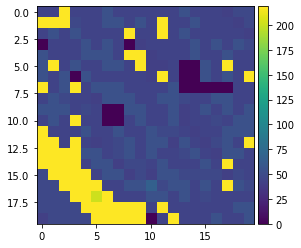

In [84]:
print(dx_map.shape)
ax = plt.subplot(111)
im = ax.imshow(theta_map)

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


In [ ]:
def plot_4(d, num, cmap):

    fig, axs = plt.subplots(2, 2, figsize=(20,20))
    fig.suptitle('Strain maps '+str(num))
    Nr = 2
    Nc = 2
    images = []
    data = [d.strain_11[:,:,num], d.strain_22[:,:,num], d.strain_12[:,:,num], d.strain_eff[:,:,num]]
    names = ["11", "22", "12", "effective"]
    no = 0
    for i in range(Nr):
        for j in range(Nc):
            vmin = np.mean(data[no].flatten()) - 1*np.std(data[no].flatten())
            vmax = np.mean(data[no].flatten()) + 1*np.std(data[no].flatten())
            images.append(axs[i, j].imshow(data[no], cmap=cmap, vmin=0, vmax=0.3))
            axs[i, j].set_title(names[no])
            axs[i, j].label_outer()
            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            fig.colorbar(images[no], ax=axs[i,j], shrink=0.6)
            no += 1
    plt.show()
    
    
    return fig, axs

fig, axs = plot_4(dic_2ndpass, 0, 'RdBu')

fig.savefig('STRAINS_'+str(roi_2ndpass['size_pass'])+'_'+str(roi_2ndpass['overlap_percentage']), dpi=400)